# Benchmarking of Graph Network

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
from moleculekit.molecule import Molecule
from moleculekit.periodictable import periodictable
import numpy as np
import torch as pt
from torch.utils.benchmark import Timer
from torchmdnet.models.model import create_model
from torchmdnet.optimize import optimize as optimize_model

## Models

In [2]:
# Graph network (default)
model_1 = create_model({
    'embedding_dimension': 128,
    'num_layers': 6,
    'num_rbf': 50,
    'rbf_type': 'expnorm',
    'trainable_rbf': True,
    'activation': 'silu',
    'neighbor_embedding': True,
    'cutoff_lower': 0.0,
    'cutoff_upper': 5.0,
    'max_z': 100,
    'max_num_neighbors': 32,
    'model': 'graph-network',
    'aggr': 'add',
    'derivative': False,
    'atom_filter': -1,
    'prior_model': None,
    'output_model': 'Scalar',
    'reduce_op': 'add'
})

# Graph network (compatible with NNPOps, https://github.com/torchmd/torchmd-net/issues/48),
# i.e. rbf_type='gauss', trainable_rbf=False, activation='ssp', and neighbor_embedding=False
model_2 = create_model({
    'embedding_dimension': 128,
    'num_layers': 6,
    'num_rbf': 50,
    'rbf_type': 'gauss',
    'trainable_rbf': False,
    'activation': 'ssp',
    'neighbor_embedding': False,
    'cutoff_lower': 0.0,
    'cutoff_upper': 5.0,
    'max_z': 100,
    'max_num_neighbors': 32,
    'model': 'graph-network',
    'aggr': 'add',
    'derivative': False,
    'atom_filter': -1,
    'prior_model': None,
    'output_model': 'Scalar',
    'reduce_op': 'add'
})

## Benchmarking function

In [3]:
def benchmark(model, pdb_file, device, optimize=True, compute_forces=True, compute_derivatives=False, batch_size=1):

    # Optimize the model
    model = deepcopy(model).to(device)
    if optimize:
        assert not compute_derivatives
        assert batch_size == 1
        model = optimize_model(model)

    # Setup the derivative computation
    for parameter in model.parameters():
        parameter.requires_grad = compute_derivatives

    # Get molecular data
    molecule = Molecule(pdb_file)
    atomic_numbers = pt.tensor([periodictable[symbol].number for symbol in molecule.element], dtype=pt.long, device=device)
    positions = pt.tensor(molecule.coords[:,:,0], dtype=pt.float32, device=device).to(device)

    # Setup a batch
    batch = pt.flatten(pt.tile(pt.arange(batch_size).unsqueeze(1), (1, len(atomic_numbers)))).to(device)
    atomic_numbers = pt.tile(atomic_numbers, (batch_size,))
    positions = pt.tile(positions, (batch_size, 1)).detach()

    # Setup the force computation
    assert not (compute_forces and (batch_size > 1))
    positions.requires_grad = compute_forces

    # Benchmark
    stmt = 'model(atomic_numbers, positions, batch)' + ('[0].backward()' if compute_forces else '')
    timer = Timer(stmt=stmt, globals=locals())
    speed = timer.blocked_autorange(min_run_time=10).median * 1000 # s --> ms

    return speed

## Speed for MD

In [4]:
device = pt.device('cuda')
systems = [('systems/alanine_dipeptide.pdb', 'ALA2'),
           ('systems/chignolin.pdb', 'CLN'),
           ('systems/dhfr.pdb', 'DHFR'),
           ('systems/factorIX.pdb', 'FC9'),
           ('systems/stmv.pdb', 'STMV')]

methods = [('default', model_1, False),
           ('compatible', model_2, False),
           ('optimized', model_2, True)]

speed_methods = {}
for meth, model, optimize in methods:
    speed_methods[meth] = {}
    print(f'Method: {meth}')
    for pdb_file, name in systems:
        try:
            speed = benchmark(model, pdb_file, device, optimize=optimize, compute_forces=True, compute_derivatives=False, batch_size=1)
            speed_methods[meth][name] = speed
            print(f'  {name}: {speed} ms/it')
        except Exception as e:
            print(f'  {name}: failed')

Method: default
  ALA2: 8.512677857652307 ms/it
  CLN: 9.068553801625967 ms/it
  DHFR: 27.531512710265815 ms/it
  FC9: 66.58423482440412 ms/it
  STMV: failed
Method: compatible
  ALA2: 7.355840795207769 ms/it
  CLN: 7.8302320395596325 ms/it
  DHFR: 25.765781197696924 ms/it
  FC9: 62.86521896254271 ms/it
  STMV: failed
Method: optimized
  ALA2: 2.842827159911394 ms/it
  CLN: 2.9062073002569377 ms/it
  DHFR: 21.249367343261838 ms/it
  FC9: 49.01586705818772 ms/it
  STMV: 218.77396607305855 ms/it


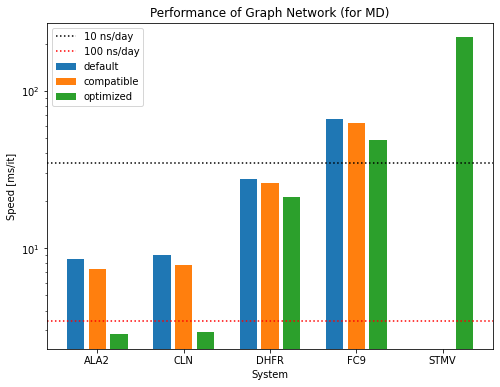

In [5]:
plt.figure(figsize=(8,6))

labels = []
for i, (meth, speeds) in enumerate(speed_methods.items()):
    labels = speeds.keys() if len(speeds.keys()) > len(labels) else labels
    x = np.arange(len(speeds)) + 0.25*i - 0.25
    plt.bar(x, speeds.values(), width=0.2, log=True, label=meth)

plt.axhline(34.56, color='black', linestyle=':', label='10 ns/day')
plt.axhline(3.456, color='red', linestyle=':', label='100 ns/day')

plt.title('Performance of Graph Network (for MD)')
plt.xlabel('System')
plt.xticks(np.arange(len(labels)), labels)
plt.ylabel('Speed [ms/it]')
plt.legend()
plt.show()

## Speed for inference and training

In [6]:
device = pt.device('cuda')
systems = [('systems/alanine_dipeptide.pdb', 'ALA2'),
           ('systems/chignolin.pdb', 'CLN'),
           ('systems/dhfr.pdb', 'DHFR'),
           ('systems/factorIX.pdb', 'FC9'),
           ('systems/stmv.pdb', 'STMV')]

speed_inference = {}
for pdb_file, name in systems:
    speed_inference[name] = {}
    print(f'System: {name}')
    for batch_size in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024):
        try:
            speed = benchmark(model_1, pdb_file, device, optimize=False, compute_forces=False, compute_derivatives=False, batch_size=batch_size)
            speed_inference[name][batch_size] = speed
            print(f'  {batch_size}: {speed} ms/it')
        except Exception as e:
            print(f'  {batch_size}: failed')

System: ALA2
  1: 2.516892839921638 ms/it
  2: 2.5424842443317175 ms/it
  4: 2.5531893398147076 ms/it
  8: 2.6369541557505727 ms/it
  16: 2.6726964500267054 ms/it
  32: 2.7393237804062665 ms/it
  64: 4.26044347579591 ms/it
  128: 7.244092703331262 ms/it
  256: 13.145896792411804 ms/it
  512: 24.881171784363687 ms/it
  1024: 48.470293870195746 ms/it
System: CLN
  1: 2.7015579992439593 ms/it
  2: 2.7713687205687165 ms/it
  4: 3.7612814898602664 ms/it
  8: 6.168047711253166 ms/it
  16: 10.8185333898291 ms/it
  32: 20.151227607857436 ms/it
  64: 38.67060805205255 ms/it
  128: 76.10373303759843 ms/it
  256: 151.7805299954489 ms/it
  512: 303.3859474817291 ms/it
  1024: 606.7570841405541 ms/it
System: DHFR
  1: 14.654869702644646 ms/it
  2: 24.242397001944486 ms/it
  4: 43.808905011974275 ms/it
  8: 82.46600651182234 ms/it
  16: 160.88764695450664 ms/it
  32: 321.02681254036725 ms/it
  64: 627.799557056278 ms/it
  128: failed
  256: failed
  512: failed
  1024: failed
System: FC9
  1: 37.751

In [7]:
device = pt.device('cuda')
systems = [('systems/alanine_dipeptide.pdb', 'ALA2'),
           ('systems/chignolin.pdb', 'CLN'),
           ('systems/dhfr.pdb', 'DHFR'),
           ('systems/factorIX.pdb', 'FC9'),
           ('systems/stmv.pdb', 'STMV')]

speed_training = {}
for pdb_file, name in systems:
    speed_training[name] = {}
    print(f'System: {name}')
    for batch_size in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024):
        try:
            speed = benchmark(model_1, pdb_file, device, optimize=False, compute_forces=False, compute_derivatives=True, batch_size=batch_size)
            speed_training[name][batch_size] = speed
            print(f'  {batch_size}: {speed} ms/it')
        except Exception as e:
            print(f'  {batch_size}: failed')

System: ALA2
  1: 2.7167771686799824 ms/it
  2: 2.7412522002123296 ms/it
  4: 2.781942819710821 ms/it
  8: 2.847177425865084 ms/it
  16: 2.8608009684830904 ms/it
  32: 2.876395189668983 ms/it
  64: 4.328028759919107 ms/it
  128: 7.302894513122737 ms/it
  256: 13.164572499226777 ms/it
  512: 24.910034309141338 ms/it
  1024: 48.43969410285354 ms/it
System: CLN
  1: 2.839836374623701 ms/it
  2: 2.998533679638058 ms/it
  4: 3.8559730001725256 ms/it
  8: 6.254713446833193 ms/it
  16: 10.888415342196822 ms/it
  32: 20.23457575123757 ms/it
  64: 38.72939640423283 ms/it
  128: failed
  256: failed
  512: failed
  1024: failed
System: DHFR
  1: 14.701791352126747 ms/it
  2: 24.365028645843264 ms/it
  4: 43.760383292101324 ms/it
  8: failed
  16: failed
  32: failed
  64: failed
  128: failed
  256: failed
  512: failed
  1024: failed
System: FC9
  1: 37.839295994490385 ms/it
  2: 61.413893941789865 ms/it
  4: failed
  8: failed
  16: failed
  32: failed
  64: failed
  128: failed
  256: failed


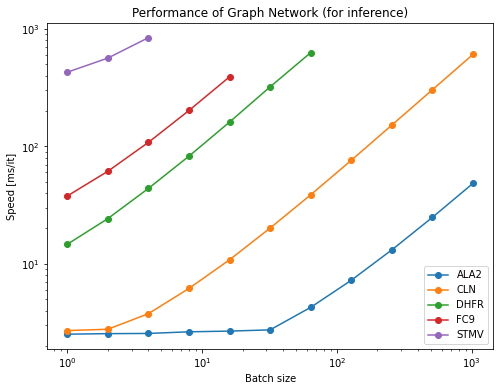

In [8]:
plt.figure(figsize=(8,6))

for name, speeds in speed_inference.items():
    plt.plot(speeds.keys(), speeds.values(), label=name, marker='o')

plt.title('Performance of Graph Network (for inference)')
plt.xlabel('Batch size')
plt.ylabel('Speed [ms/it]')
plt.loglog()
plt.legend()
plt.show()

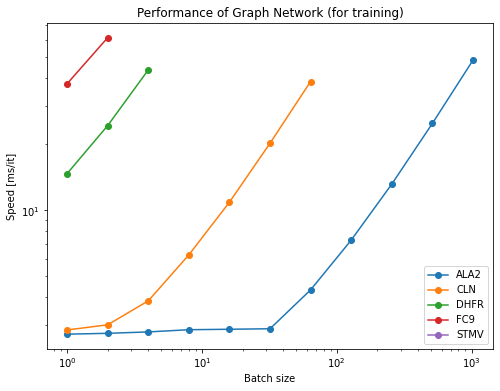

In [9]:
plt.figure(figsize=(8,6))

for name, speeds in speed_training.items():
    plt.plot(speeds.keys(), speeds.values(), label=name, marker='o')

plt.title('Performance of Graph Network (for training)')
plt.xlabel('Batch size')
plt.ylabel('Speed [ms/it]')
plt.loglog()
plt.legend()
plt.show()